In [1]:
import numpy as np
import pandas as pd
from numpy.random import randn

import edhec_risk_kit as erk

%matplotlib inline

%load_ext autoreload
%autoreload 2

- The normal distribution underestimates the risk for extreme returns.
- Look at higher-order moments: skewness and kurtosis
- Some hedge fund strategies (e.g. Convertible Arb) have strong negative skewness (think -2.7) and strong positive kurtosis (think 23.3).
  - This is what "Picking up pennies in front of a steamroller" means, I think
  - Most days your return is slightly above average, but there are heavy negative outlier days too
  - Negative skewness means the negative outliers are more severe than the positive ones
- **High negative skewness implies that the symmetric std does not capture downside risk completely!**

### Histogram of negatively skewed (theta = -2.5) random variable

[Method](https://pdfs.semanticscholar.org/5198/32c082b6265827205c97764cf77f705a979c.pdf)

I didn't manage to simulate a high-kurtosis RV (as described [here](https://stats.stackexchange.com/a/43487/2091))

In [2]:
n = 1000
theta = -2.5  # negative skewness
U = randn(n)
V = randn(n)
X = (theta * np.abs(U) + V) / np.sqrt(1 + theta**2)

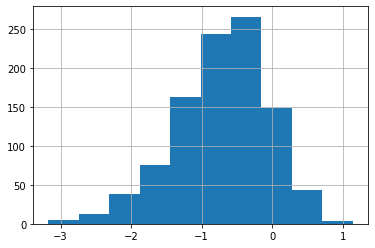

In [3]:
pd.Series(X).hist()

### Semi-volatility / semi-deviation

- The volatility of the subsample of below-average (or below-zero) returns
- Important for asymmetric distributions
- Because we don't care about upside volatility, in fact we welcome it

### Value at Risk (VaR)

- Maximum "expected" loss over a given time period
- You must define a confidence level, e.g. 99%
- Exclude 1% worst losses, then compute the worst-case
- errrm, it's just the (absolute value of the) 1% quantile of the return distribution for a specified time period (e.g. weekly)

### Distribution beyond VaR / CVaR

- Expected shortfall (loss) if you fall below the VaR
- $CVaR = -E(R|R \leq -VaR)$

----

### Using the ERK module

In [4]:
returns = erk.get_ffme_returns()

In [5]:
erk.drawdown(returns['SmallCap'])

,Wealth,Previous Peak,Drawdown
date,,,
1926-07,9.855000e+02,9.855000e+02,0.000000
1926-08,1.035958e+03,1.035958e+03,0.000000
1926-09,1.045592e+03,1.045592e+03,0.000000
1926-10,9.949854e+02,1.045592e+03,-0.048400
1926-11,9.872245e+02,1.045592e+03,-0.055822
...,...,...,...
2019-10,1.711126e+09,2.218118e+09,-0.228569
2019-11,1.733370e+09,2.218118e+09,-0.218540
2019-12,1.844306e+09,2.218118e+09,-0.168527


----

### The EDHEC hedge fund indices

In [6]:
hfi = erk.get_hfi_returns()

Check it out, negative skewness and heavy kurtosis!

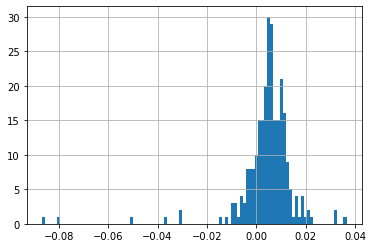

In [7]:
hfi['Fixed Income Arbitrage'].hist(bins=100)

In [8]:
hfi['Fixed Income Arbitrage'].mean()

0.004365019011406845

In [9]:
hfi['Fixed Income Arbitrage'].median()

0.0055000000000000005

In [10]:
hfi['Fixed Income Arbitrage'].skew()

-3.9629586210448275

In [11]:
hfi['Fixed Income Arbitrage'].kurtosis()

27.382747416527913

----

In [12]:
hfi.skew().sort_values()

Fixed Income Arbitrage   -3.962959
Convertible Arbitrage    -2.654757
Equity Market Neutral    -2.136641
Relative Value           -1.825900
Event Driven             -1.417250
Merger Arbitrage         -1.327668
Distressed Securities    -1.308316
Emerging Markets         -1.173773
Long/Short Equity        -0.392469
Funds Of Funds           -0.363862
CTA Global                0.174697
Short Selling             0.772387
Global Macro              0.988569
dtype: float64

In [13]:
hfi.kurtosis().sort_values()

CTA Global                -0.024781
Long/Short Equity          1.576431
Global Macro               2.817691
Short Selling              3.201032
Funds Of Funds             4.171770
Distressed Securities      5.007403
Event Driven               5.156059
Merger Arbitrage           5.872733
Emerging Markets           6.394438
Relative Value             9.320184
Equity Market Neutral     14.515783
Convertible Arbitrage     20.694912
Fixed Income Arbitrage    27.382747
dtype: float64

## Test for normality: Jarque-Bera

In [14]:
from scipy.stats import jarque_bera

In [15]:
jarque_bera(hfi['CTA Global'])  # (Test statistic, p value)

(1.3467529104392226, 0.5099837302620382)

In [16]:
jarque_bera(hfi['Convertible Arbitrage'])

(4812.703130094962, 0.0)

For each column in the HFI data, return whether the p-value is greater than 0.01.

(Check out the **aggregate** function!)

In [17]:
def passes_jarque_bera(returns):
    return jarque_bera(returns)[1] > 0.01

hfi.aggregate(passes_jarque_bera)

Convertible Arbitrage     False
CTA Global                 True
Distressed Securities     False
Emerging Markets          False
Equity Market Neutral     False
Event Driven              False
Fixed Income Arbitrage    False
Global Macro              False
Long/Short Equity         False
Merger Arbitrage          False
Relative Value            False
Short Selling             False
Funds Of Funds            False
dtype: bool

----

In [18]:
ffme = erk.get_ffme_returns()
ffme.skew()

SmallCap    4.418948
LargeCap    0.226780
dtype: float64

**Positive skew** is good! That means the outliers are positive returns more often than not!

In [19]:
ffme.kurtosis()

SmallCap    44.212285
LargeCap     7.699352
dtype: float64

The kurtosis of Small Caps is atrocious!

In [20]:
ffme.aggregate(passes_jarque_bera)

SmallCap    False
LargeCap    False
dtype: bool

They're also not normally distributed (duh).

# Computing/Estimating VaR

There are at least four standard methods:

1. Historical (non-parametric)
    - Just look at historical returns and take the 5% quantile
    - Pro: No assumption, very simple
    - Con: You only rely on historical data. Change the time frame a bit, get a much different result
      - You're **taking on a lot of sample risk**
2. Variance-Covariance (parametric Gaussian)
    - parametric: Make assumptions about the return distribution
    - Take the 5% quantile of the Gaussian with $\mu = \bar{x}$ and $\sigma = s_x$
    - You're **taking on a lot of model risk**, because the Gaussian is a wrong assumption.
    - The risk underestimation is higher for higher quantiles (e.g. 99.9% instead of 95%)
3. Parametric Non-gaussian
    - e.g. Pareto, Student, Log-Gamma, Frechet
4. Cornish-Fisher VaR (semi-parametric)
    - no distribution assumption
    - 1937: Cornish-Fisher expansion
      - map the $\alpha$-quantile of a Gaussian to the $\alpha$-quantile of an arbitrary distribution with a certain skewness and kurtosis
      - **wow!**
      - very commonly used method, often the best choice in a **trade-off between sample risk and model risk.**
      - $\tilde{z}_a = z_a + \frac{1}{6}(z_a^2 - 1)S + \frac{1}{24}(z_a^3-3z_a)(K-3) - \frac{1}{36}(2z_a^3-5z_a)S^2$
        - S = skew, K = kurtosis


# Lab session: Semi-deviation, VaR and CVaR

### Standard deviation

In [21]:
hfi.std()

Convertible Arbitrage     0.016567
CTA Global                0.023335
Distressed Securities     0.017042
Emerging Markets          0.032538
Equity Market Neutral     0.008130
Event Driven              0.016744
Fixed Income Arbitrage    0.011539
Global Macro              0.014722
Long/Short Equity         0.019935
Merger Arbitrage          0.009619
Relative Value            0.011484
Short Selling             0.047746
Funds Of Funds            0.015566
dtype: float64

### Semi-deviation

In [22]:
hfi[hfi < 0].std()

Convertible Arbitrage     0.019687
CTA Global                0.012495
Distressed Securities     0.015288
Emerging Markets          0.028197
Equity Market Neutral     0.009667
Event Driven              0.015536
Fixed Income Arbitrage    0.017940
Global Macro              0.006612
Long/Short Equity         0.014133
Merger Arbitrage          0.008954
Relative Value            0.012355
Short Selling             0.027377
Funds Of Funds            0.012191
dtype: float64

# VaR

### Historic VaR

In [23]:
ffme.quantile(0.05)

SmallCap   -0.107085
LargeCap   -0.075565
Name: 0.05, dtype: float64

In [24]:
hfi.quantile(0.05)

Convertible Arbitrage    -0.01576
CTA Global               -0.03169
Distressed Securities    -0.01966
Emerging Markets         -0.04247
Equity Market Neutral    -0.00814
Event Driven             -0.02535
Fixed Income Arbitrage   -0.00787
Global Macro             -0.01499
Long/Short Equity        -0.02598
Merger Arbitrage         -0.01047
Relative Value           -0.01174
Short Selling            -0.06783
Funds Of Funds           -0.02047
Name: 0.05, dtype: float64

So the worst 1% of SmallCaps' months lose 20% or more.

### Parametric VaR (Gaussian)

Because: *We shouldn't take what we saw literally, because it really was just one sample of the many possible ways it could have gone.* So let's treat that as a sample, and impose a model on it.

In [25]:
from scipy.stats import norm

In [26]:
z = norm.ppf(0.05)  # ppf == qnorm in R
z

-1.6448536269514729

In [27]:
ffme.mean() + z * ffme.std()  # plus because the quantile is negative

SmallCap   -0.156680
LargeCap   -0.079553
dtype: float64

In [28]:
hfi.mean() + z * hfi.std()  # plus because the quantile is negative

Convertible Arbitrage    -0.021743
CTA Global               -0.034308
Distressed Securities    -0.021085
Emerging Markets         -0.047266
Equity Market Neutral    -0.008875
Event Driven             -0.021196
Fixed Income Arbitrage   -0.014615
Global Macro             -0.018813
Long/Short Equity        -0.026459
Merger Arbitrage         -0.010466
Relative Value           -0.013097
Short Selling            -0.080236
Funds Of Funds           -0.021341
dtype: float64

### Modified Cornish-Fisher VaR

All you do is update $z_\alpha$ to a new value based on the formula specified above

**Note/TODO**: It seems to work well for the HFI data frame, but not at all for the SmallCaps. Why is that?

In [35]:
alpha = 0.05
z = norm.ppf(alpha)

s = ffme.skew()
k = ffme.kurtosis()

z_updated = (
    z + 
    (z**2 - 1) * s/6 +
    (z**3 - 3*z) * (k-3)/24 -
    (2*z**3 - 5*z) * (s**2)/36
)

In [36]:
z_updated

SmallCap    0.809731
LargeCap   -1.484587
dtype: float64

In [31]:
ffme.mean() + z_updated * ffme.std()

SmallCap    0.103206
LargeCap   -0.070931
dtype: float64

----

In [32]:
alpha = 0.05
z = norm.ppf(alpha)

s = hfi.skew()
k = hfi.kurtosis()

z_updated = (
    z + 
    (z**2 - 1) * s/6 +
    (z**3 - 3*z) * (k-3)/24 -
    (2*z**3 - 5*z) * (s**2)/36
)

In [33]:
z_updated

Convertible Arbitrage    -1.910015
CTA Global               -1.655664
Distressed Securities    -1.944091
Emerging Markets         -1.884127
Equity Market Neutral    -1.934065
Event Driven             -1.966479
Fixed Income Arbitrage   -1.984308
Global Macro             -1.349169
Long/Short Equity        -1.782251
Merger Arbitrage         -1.931171
Relative Value           -1.973713
Short Selling            -1.410035
Funds Of Funds           -1.722150
dtype: float64

In [34]:
hfi.mean() + z_updated * hfi.std()

Convertible Arbitrage    -0.026136
CTA Global               -0.034560
Distressed Securities    -0.026185
Emerging Markets         -0.055052
Equity Market Neutral    -0.011226
Event Driven             -0.026581
Fixed Income Arbitrage   -0.018532
Global Macro             -0.014459
Long/Short Equity        -0.029198
Merger Arbitrage         -0.013220
Relative Value           -0.016874
Short Selling            -0.069024
Funds Of Funds           -0.022544
dtype: float64

# BeyondVar aka CVaR

- Given you'll perform worse than the VaR, how much can you expect to lose?
- Just compute the average of all returns that are below the VaR

### Historic CVaR

In [45]:
smallcap_var_05 = ffme['SmallCap'].quantile(0.05)

In [46]:
ffme['SmallCap'][ffme['SmallCap'] < smallcap_var_05].mean()

-0.16161228070175435